In [1]:
%pip install Sastrawi

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import nltk

In [110]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\LimDaenery93\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [140]:
import pandas as pd
import matplotlib.pyplot as plt
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


In [141]:
# Load dataset
df = pd.read_csv('smart_locker_reviews.csv', sep=";")

In [142]:
df

,review,sentiment
0,"Kualitas smart locker ini sangat buruk, sering...",Negative
1,Desain smart locker sangat modern dan menarik.,Positive
2,Smart locker ini memiliki fitur yang cukup sta...,Neutral
3,"Keamanan smart locker ini sangat tinggi, saya ...",Positive
4,Smart locker ini sering tidak bisa diakses saa...,Negative
...,...,...
871,Sistem face detection di smart locker ini terk...,Negative
872,Smart locker ini memberikan keamanan tambahan ...,Positive
873,Face detection di smart locker ini kurang resp...,Negative
874,RFID pada smart locker ini belum memenuhi kebu...,Negative


### Case Folding

In [143]:
# Ensure reviews are strings and lowercase
df['review'] = df['review'].astype(str).str.lower()

In [144]:
def clean_text(text):
    # Remove punctuation and special characters
    text = re.sub(r'[^\w\s]', '', text)
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    return text

df['cleaned_review'] = df['review'].apply(clean_text)

### Tokenizing

In [145]:
df['tokens'] = df['cleaned_review'].apply(word_tokenize)

### Stopword Removal

In [146]:
stop_words = set(stopwords.words('indonesian'))

def remove_stopwords(text):
    return [word for word in text if word not in stop_words]

df['tokens'] = df['tokens'].apply(remove_stopwords)

### Stemming

In [147]:
factory = StemmerFactory()
stemmer = factory.create_stemmer()

def stem_tokenizer(text):
    return [stemmer.stem(word) for word in text]

df['tokens'] = df['tokens'].apply(stem_tokenizer)
df['processed_review'] = df['tokens'].apply(lambda x: ' '.join(x))

### Pembobotan TF-IDF

In [148]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, min_df=1, ngram_range=(1, 1))
tfidf_matrix = tfidf_vectorizer.fit_transform(df['processed_review'])

In [149]:
# Menampilkan 10 kata dengan nilai IDF tertinggi
freqs = tfidf_matrix.sum(axis=0)
idf_values = tfidf_vectorizer.idf_
word_idf = dict(zip(tfidf_vectorizer.get_feature_names_out(), idf_values))

top_idf_words = sorted(word_idf.items(), key=lambda x: x[1], reverse=True)[:10]
for word, idf in top_idf_words:
    print(f'Kata: {word}, Kemunculan: {idf}')

Kata: adaptasi, Kemunculan: 7.083359811812238
Kata: aktif, Kemunculan: 7.083359811812238
Kata: bahan, Kemunculan: 7.083359811812238
Kata: beda, Kemunculan: 7.083359811812238
Kata: beli, Kemunculan: 7.083359811812238
Kata: benerbener, Kemunculan: 7.083359811812238
Kata: biasabiasa, Kemunculan: 7.083359811812238
Kata: buangbuang, Kemunculan: 7.083359811812238
Kata: cepet, Kemunculan: 7.083359811812238
Kata: colok, Kemunculan: 7.083359811812238


### klasifikasi SVM

In [150]:
X_train, X_test, y_train, y_test = train_test_split(tfidf_matrix, df['sentiment'], test_size=0.2, random_state=42)

model = svm.SVC(C=10, kernel='rbf', gamma=1)
model.fit(X_train, y_train)

SVC(C=10, gamma=1)

In [151]:
pred = model.predict(X_test)
pred

array(['Positive', 'Positive', 'Positive', 'Positive', 'Neutral',
       'Positive', 'Positive', 'Positive', 'Negative', 'Neutral',
       'Positive', 'Positive', 'Negative', 'Neutral', 'Positive',
       'Negative', 'Neutral', 'Positive', 'Neutral', 'Negative',
       'Positive', 'Negative', 'Positive', 'Positive', 'Neutral',
       'Negative', 'Negative', 'Positive', 'Neutral', 'Positive',
       'Positive', 'Neutral', 'Neutral', 'Positive', 'Positive',
       'Positive', 'Positive', 'Positive', 'Positive', 'Negative',
       'Negative', 'Negative', 'Negative', 'Positive', 'Negative',
       'Positive', 'Positive', 'Positive', 'Positive', 'Positive',
       'Negative', 'Negative', 'Neutral', 'Negative', 'Positive',
       'Negative', 'Negative', 'Positive', 'Negative', 'Positive',
       'Negative', 'Positive', 'Positive', 'Positive', 'Neutral',
       'Positive', 'Positive', 'Positive', 'Negative', 'Positive',
       'Positive', 'Positive', 'Negative', 'Negative', 'Negative',
      

In [152]:
print(f"Accuracy : {model.score(X_test, y_test)}")

Accuracy : 0.8636363636363636


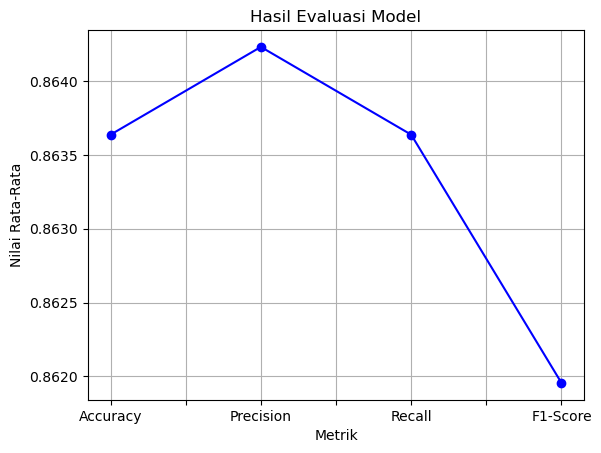

In [153]:
pred = model.predict(X_test)
acc_score = accuracy_score(y_test, pred) 
pre_score = precision_score(y_test, pred, average='weighted')
rec_score = recall_score(y_test, pred, average='weighted')
f_score = f1_score(y_test, pred, average='weighted')

scores = {
    'Accuracy': acc_score,
    'Precision': pre_score,
    'Recall': rec_score, 
    'F1-Score': f_score
}

eval_df = pd.DataFrame.from_dict(scores, orient='index', columns=['Score']) 

eval_df['Score'].plot(kind='line', marker='o', color='blue') 

plt.title('Hasil Evaluasi Model')
plt.xlabel('Metrik') 
plt.ylabel('Nilai Rata-Rata')
plt.grid(True) 

plt.show()

In [154]:
# Evaluasi pada training set
y_train_pred = model.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)
print("Training Accuracy:", train_accuracy)
print("Training Classification Report:")
print(classification_report(y_train, y_train_pred))

# Evaluasi pada testing set
y_test_pred = model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print("Testing Accuracy:", test_accuracy)
print("Testing Classification Report:")
print(classification_report(y_test, y_test_pred))

Training Accuracy: 0.9814285714285714
Training Classification Report:
              precision    recall  f1-score   support

    Negative       0.99      0.97      0.98       221
     Neutral       0.97      0.99      0.98       151
    Positive       0.98      0.98      0.98       328

    accuracy                           0.98       700
   macro avg       0.98      0.98      0.98       700
weighted avg       0.98      0.98      0.98       700

Testing Accuracy: 0.8636363636363636
Testing Classification Report:
              precision    recall  f1-score   support

    Negative       0.87      0.85      0.86        53
     Neutral       0.88      0.74      0.80        38
    Positive       0.86      0.93      0.89        85

    accuracy                           0.86       176
   macro avg       0.87      0.84      0.85       176
weighted avg       0.86      0.86      0.86       176



In [155]:
def preprocess_review(review):
    review = review.lower()
    tokens = word_tokenize(review)
    tokens = remove_stopwords(tokens)
    tokens = stem_tokenizer(tokens)
    return ' '.join(tokens)

def predict_sentiment(review):
    preprocessed_review = preprocess_review(review)
    tfidf_review = tfidf_vectorizer.transform([preprocessed_review])
    sentiment = model.predict(tfidf_review)
    return sentiment[0]

In [158]:
new_reviews = [
    "gagal",
    "ini bagus banget",
    "ini keren banget anjing",
    "ini kayak tai dah, lockernya",
    "bagus banget sangat membantu",
    "ini efektif dan efisien",
    "ini keren banget si",
    "lumayan lah ya"
]
for review in new_reviews:
    sentiment = predict_sentiment(review)
    print(f"Review: {review}\nPredicted Sentiment: {sentiment}\n")

Review: gagal
Predicted Sentiment: Negative

Review: ini bagus banget
Predicted Sentiment: Positive

Review: ini keren banget anjing
Predicted Sentiment: Positive

Review: ini kayak tai dah, lockernya
Predicted Sentiment: Negative

Review: bagus banget sangat membantu
Predicted Sentiment: Positive

Review: ini efektif dan efisien
Predicted Sentiment: Positive

Review: ini keren banget si
Predicted Sentiment: Positive

Review: lumayan lah ya
Predicted Sentiment: Neutral

Review: loker tidak bisa di buka
Predicted Sentiment: Positive



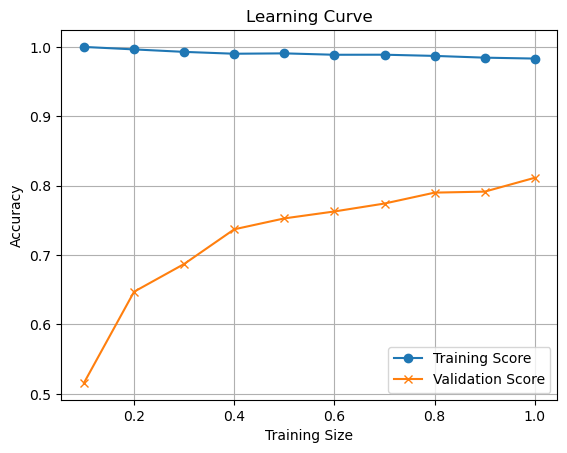

In [159]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, X, y, cv=None, train_sizes=np.linspace(0.1, 1.0, 10)):
    train_scores, test_scores = [], []
    for train_size in train_sizes:
        _, train_score, test_score = learning_curve(estimator, X, y, cv=cv, train_sizes=[train_size])
        train_scores.append(train_score.mean())
        test_scores.append(test_score.mean())
    plt.plot(train_sizes, train_scores, label='Training Score', marker='o')
    plt.plot(train_sizes, test_scores, label='Validation Score', marker='x')
    plt.title('Learning Curve')
    plt.xlabel('Training Size')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

X_train, X_val, y_train, y_val = train_test_split(tfidf_matrix, df['sentiment'], test_size=0.2, random_state=42)
model = svm.SVC(C=10, kernel='rbf', gamma=1)

plot_learning_curve(model, X_train, y_train, cv=5)
plt.show()

In [160]:
import joblib

joblib.dump(model, 'sentiment.pkl')
joblib.dump(tfidf_vectorizer, 'tfidf_vectorizer.pkl')

['tfidf_vectorizer.pkl']

### Find Best Parameters

In [130]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'tfidf__max_df': [0.7, 0.75, 0.8, 0.85, 0.9, 0.95],
    'tfidf__min_df': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'svm__C': [0.1, 1, 10],
    'svm__gamma': [0.01, 0.1, 1],
    'svm__kernel': ['linear', 'rbf', 'poly', 'sigmoid']
}

In [131]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('svm', svm.SVC())
])

In [132]:
grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(df['processed_review'], df['sentiment'])

Fitting 5 folds for each of 4320 candidates, totalling 21600 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('svm', SVC())]),
             n_jobs=-1,
             param_grid={'svm__C': [0.1, 1, 10], 'svm__gamma': [0.01, 0.1, 1],
                         'svm__kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
                         'tfidf__max_df': [0.7, 0.75, 0.8, 0.85, 0.9, 0.95],
                         'tfidf__min_df': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'tfidf__ngram_range': [(1, 1), (1, 2)]},
             verbose=2)

In [135]:
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation score: ", grid_search.best_score_)

Best parameters found:  {'svm__C': 10, 'svm__gamma': 1, 'svm__kernel': 'rbf', 'tfidf__max_df': 0.85, 'tfidf__min_df': 1, 'tfidf__ngram_range': (1, 1)}
Best cross-validation score:  0.7567987012987013


In [138]:
from sklearn.model_selection import RandomizedSearchCV

param_dist = {
    'tfidf__max_df': [0.7, 0.75, 0.8, 0.85, 0.9, 0.95],
    'tfidf__min_df': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'svm__C': np.logspace(-2, 1, 4),
    'svm__gamma': np.logspace(-2, 1, 4),
    'svm__kernel': ['linear', 'rbf', 'poly', 'sigmoid']
}

In [139]:
random_search = RandomizedSearchCV(pipeline, param_distributions=param_dist, n_iter=2160, cv=5, n_jobs=-1, verbose=2, random_state=42)
random_search.fit(df['processed_review'], df['sentiment'])

Fitting 5 folds for each of 2160 candidates, totalling 10800 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                             ('svm', SVC())]),
                   n_iter=2160, n_jobs=-1,
                   param_distributions={'svm__C': array([ 0.01,  0.1 ,  1.  , 10.  ]),
                                        'svm__gamma': array([ 0.01,  0.1 ,  1.  , 10.  ]),
                                        'svm__kernel': ['linear', 'rbf', 'poly',
                                                        'sigmoid'],
                                        'tfidf__max_df': [0.7, 0.75, 0.8, 0.85,
                                                          0.9, 0.95],
                                        'tfidf__min_df': [1, 2, 3, 4, 5, 6, 7,
                                                          8, 9, 10],
                                        'tfidf__ngram_range': [(1, 1), (1, 2)]},
                   random_state=42, verbose=2)

In [119]:
print("Best parameters found: ", random_search.best_params_)
print("Best cross-validation score: ", random_search.best_score_)

Best parameters found:  {'tfidf__ngram_range': (1, 1), 'tfidf__min_df': 1, 'tfidf__max_df': 0.8, 'svm__kernel': 'rbf', 'svm__gamma': 1.0, 'svm__C': 10.0}
Best cross-validation score:  0.7545259740259741
